In [1]:
from pathlib import Path
from joblib import dump, load
import pandas as pd
import numpy as np
from IPython.display import Markdown
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder, StandardScaler, RobustScaler, OrdinalEncoder, LabelEncoder
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import ShuffleSplit, cross_validate, GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, make_scorer
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data_path = Path('../data/raw/data.csv')
dict_path = Path('../data/external/dicionario.csv')
n_splits = 30
n_folds = 5

In [3]:
df =  pd.read_csv(data_path)
display(Markdown("### Conjunto de dados"))
display(df.head())

df_dict =  pd.read_csv(dict_path)
display(Markdown("### Dicionário de dados"))
display(df_dict.head())

### Conjunto de dados

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
0,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,15,16,2,20,Yes,Good,Under-7,M
1,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,20,20,3,25,Yes,Good,Under-7,M
2,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,10,7,0,30,No,Bad,Above-7,L
3,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,30,25,5,35,No,Bad,Above-7,L
4,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,40,50,12,50,No,Bad,Above-7,M


### Dicionário de dados

,variavel,significado,valores,tipo
0,gender,Gênero do estudante,"[""Male"", ""Female""]",Nominal
1,NationalITy,Nacionalidade do estudante,"[""Kuwait"", ""Lebanon"", ""Egypt"", ""SaudiArabia"", ...",Nominal
2,PlaceofBirth,Local de nascimento do estudante,"[""Kuwait"", ""Lebanon"", ""Egypt"", ""SaudiArabia"", ...",Nominal
3,StageID,Nivel educacional do estudante,"[""lowerlevel"", ""MiddleSchool"", ""HighSchool""]",Ordinal
4,GradeID,Turma a qual o aluno pertence,"[""G-01"", ""G-02"", ""G-03"", ""G-04"", ""G-05"", ""G-06...",Nominal


In [4]:
target_column = 'Class'

nominal_columns = (
    df_dict
    .query("tipo == 'Nominal' and variavel != @target_column")
    .variavel
    .to_list()
)
ordinal_columns = (
    df_dict
    .query("tipo == 'Ordinal' and variavel != @target_column")
    .variavel
    .to_list()
)
discrete_columns = (
    df_dict
    .query("tipo == 'Discreta' and variavel != @target_column")
    .variavel
    .to_list()
)

In [5]:
nominal_preprocessor = Pipeline(steps=[
    # Tratamento de dados discrepantes
    ('missing', SimpleImputer(strategy='most_frequent')), # Tratamento de dados faltantes
    ('encoding', OneHotEncoder(sparse=False, handle_unknown='ignore')), # Codificação de variáveis
    # Seleção de variáveis
    ('normalization', StandardScaler())# Normalização
])

ordinal_preprocessor = Pipeline(steps=[
    # Tratamento de dados discrepantes
    ('missing', SimpleImputer(strategy='most_frequent')), # Tratamento de dados faltantes
    ('encoding', OrdinalEncoder()), # Codificação de variáveis
    # Seleção de variáveis
    ('normalization', StandardScaler())# Normalização
])

discrete_preprocessor = Pipeline(steps=[
    # Tratamento de dados discrepantes
    ('missing', SimpleImputer(strategy='median')), # Tratamento de dados faltantes
    # Seleção de variáveis
    ('normalization', StandardScaler())# Normalização
])

preprocessor = ColumnTransformer([
    ('nominal', nominal_preprocessor, nominal_columns),
    ('ordinal', ordinal_preprocessor, ordinal_columns),
    ('discrete', discrete_preprocessor, discrete_columns)
])

In [6]:
models = [
    (
        "LR",
        LogisticRegression(max_iter=3000, solver='liblinear', multi_class='ovr'),
        {
            "C": np.logspace(-3,3,7),
            "penalty": ["l1","l2"]
        }
    ), 
    (
        "KNN",
        KNeighborsClassifier(),
        {
            "n_neighbors": list(np.arange(3, 20, 2))
        }
    ),
    (
        "RF",
        RandomForestClassifier(),
        { 
            'n_estimators': [200, 500],
            'max_features': ['sqrt', 'log2'],
            'max_depth' : [4, 5, 6, 7, 8],
            'criterion' :['gini', 'entropy']
        }
    ),
    (
        "NB",
        BernoulliNB(),
        {
            'fit_prior': [True, False],
            'class_prior': [None, [0.1,] * 3, ],
        }
    )
    # (
    #     "BC",
    #     BaggingClassifier(DecisionTreeClassifier()),
    #     {
    #         "base_estimator__max_depth": [4, 5, 6, 7, 8],
    #         "base_estimator__ccp_alpha": [0.1, .01, .001],
    #         # "base_estimator__max_leaf_nodes": np.arange(2, 100),
    #         # "base_estimator__min_samples_leaf": [1, 3, 5, 7, 10],
    #         "base_estimator__min_samples_split": [2, 3, 4],
    #         "base_estimator__criterion": ['gini', 'entropy'],
    #         #'max_features': ['auto', 'sqrt', 'log2'],
    #         'bootstrap_features': [False, True],
    #         'max_samples': [0.5, 0.7, 1.0],
    #         'n_estimators': [2, 5, 10, 20],
    #     }
    # )
]

In [7]:
X = df.drop(columns=target_column, axis=1)
y = df[[target_column]].to_numpy().ravel()

In [8]:
cv = ShuffleSplit(n_splits=n_splits, test_size=.2, random_state=42)
results = pd.DataFrame()
for model_name, model_obj, model_params in models:
    print(f'{model_name} run...')
    model_gs = GridSearchCV(
        estimator=model_obj,
        param_grid=model_params,
        scoring='accuracy',
        n_jobs=6,
        cv=n_folds,
    )
    approach = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model_gs)
    ])
    scores = cross_validate(
        estimator=approach,
        X=X,
        y=y,
        scoring={
            'acuracia': make_scorer(accuracy_score),
            'precisão': make_scorer(precision_score, average='macro'),
            'recall': make_scorer(recall_score, average='macro')
        },
        cv=cv,
        n_jobs=6,
        verbose=1
    )
    scores["model_name"] = [model_name] * n_splits
    results = results.append(pd.DataFrame(scores))

LR run...


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:  8.9min finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


KNN run...


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    2.6s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


RF run...


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed: 20.5min finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


NB run...


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.8s finished


In [9]:
results.to_csv("data.csv")
results_data = results.copy()

In [10]:
def highlight_max(s, props=''):
    values = [float(value.split()[0]) for value in s.values[1:]]
    result = [''] * len(s.values)
    if s.values[0].endswith('time'):
        result[np.argmin(values)+1] = props
    else:
        result[np.argmax(values)+1] = props
    return result

def get_winner(s):
    metric = s.values[0]
    values = [float(value.split()[0]) for value in s.values[1:]]
    models = results.columns[1:]
    
    if s.values[0].endswith('time'):
        return models[np.argmin(values)]
    else:
        return models[np.argmax(values)]
    
results = (
    pd
    .DataFrame(results)
    .groupby(['model_name'])
    .agg([lambda x: f"{np.mean(x):.3f} ± {np.std(x):.3f}"])#
    .transpose()
    .reset_index()
    .rename(columns={"level_0": "score"})
    .drop(columns="level_1")
    # .set_index('score')
)
time_scores = ['fit_time', 'score_time']
winner = results.query('score not in @time_scores').apply(get_winner, axis=1).value_counts().index[0]
results.columns.name = ''
results = (
    results
    .style
    .hide(axis='index')
    .apply(highlight_max, props='color:white;background-color:gray', axis=1)
)

# Escolher melhor modelo
display(results)
display(Markdown(f'O melhor modelo é o : **{winner}**'))

score,KNN,LR,NB,RF
fit_time,0.494 ± 0.193,94.574 ± 94.177,0.155 ± 0.038,245.772 ± 3.843
score_time,0.022 ± 0.003,0.018 ± 0.006,0.021 ± 0.004,0.121 ± 0.057
test_acuracia,0.565 ± 0.057,0.718 ± 0.049,0.720 ± 0.045,0.786 ± 0.050
test_precisão,0.574 ± 0.058,0.727 ± 0.049,0.723 ± 0.045,0.800 ± 0.046
test_recall,0.577 ± 0.050,0.735 ± 0.047,0.746 ± 0.038,0.787 ± 0.049


O melhor modelo é o : **RF**

In [11]:
# treinar melhor modelo com todos os dados
model_name, model_obj, model_params = [
    model_tuple for model_tuple in models if model_tuple[0] == winner
][0]


model_gs = GridSearchCV(
        estimator=model_obj,
        param_grid=model_params,
        scoring='accuracy',
        n_jobs=-1,
        cv=5
)
approach = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", model_gs)
])

approach.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('nominal',
                                                  Pipeline(steps=[('missing',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoding',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False)),
                                                                  ('normalization',
                                                                   StandardScaler())]),
                                                  ['gender', 'NationalITy',
                                                   'PlaceofBirth', 'GradeID',
                                                   'SectionID', 'Topic',
                                                   'Relation',
                                                   'ParentAnsweringSurvey',
                                                   '...
                                                                   SimpleImputer(strategy='median')),
                                                                  ('normalization',
                                                                   StandardScaler())]),
                                                  ['raisedhands',
                                                   'VisITedResources',
                                                   'AnnouncementsView',
                                                   'Discussion'])])),
                ('model',
                 GridSearchCV(cv=5, estimator=RandomForestClassifier(),
                              n_jobs=-1,
                              param_grid={'criterion': ['gini', 'entropy'],
                                          'max_depth': [4, 5, 6, 7, 8],
                                          'max_features': ['sqrt', 'log2'],
                                          'n_estimators': [200, 500]},
                              scoring='accuracy'))])

In [12]:
# salvar modelo
dump(approach, '../models/model.joblib')

['../models/model.joblib']

## Visualização dos resultados

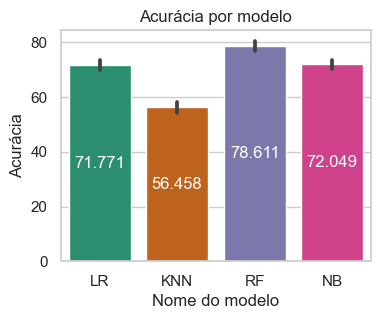

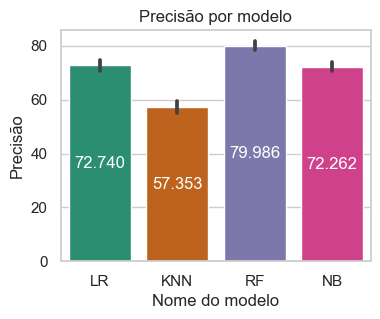

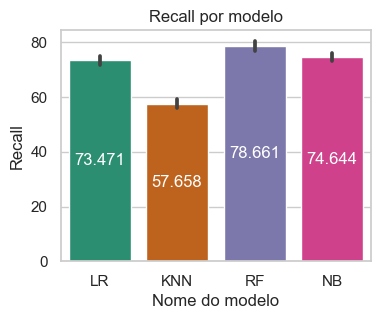

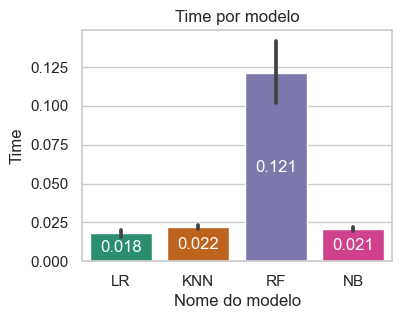

In [13]:
def porcentagem(x):
    return x*100

data = results_data[['test_acuracia','test_precisão','test_recall']].apply(porcentagem)
data['model_name'] = results_data['model_name']

def barplot(column_y, name_column_y,data):
    sns.set(style="whitegrid")
    plt.figure(figsize=(4, 3))
    ax = sns.barplot(data=data, y=column_y, x='model_name',palette='Dark2')
    ax.bar_label(
        ax.containers[0],
        fmt='%.3f',
        label_type='center',
        color='white'
    )
    plt.xlabel('Nome do modelo')
    plt.ylabel(name_column_y)
    plt.title(name_column_y + ' por modelo')
    plt.show()

barplot('test_acuracia', 'Acurácia',data)
barplot('test_precisão', 'Precisão',data)
barplot('test_recall', 'Recall',data)
barplot('score_time', 'Time',results_data)